# Лабораторная работа №6

**Сверточные нейронные сети**

---

**Впишите в эту ячейку ваши ФИО, группу**.

ФИО: Шатаров Кирилл Александрович

Группа: 211-365

---


## Загрузка данных

В данной работе будет использоваться учебный датасет с изображениями персонажей из Симпсонов. Код для скачивания и распаковки приведен ниже, его требуется только выполнить и вo вкладке Files должна появиться папка `data`, а в ней папки `train` и `test`.

In [2]:
%%time

! wget -nc http://labcolor.space/rgb-test.zip
! unzip -o -q rgb-test.zip -d data
! wget -nc http://labcolor.space/rgb-train.zip
! unzip -o -q rgb-train.zip -d data

--2024-01-25 15:27:37--  http://labcolor.space/rgb-test.zip
Resolving labcolor.space (labcolor.space)... 31.31.196.3, 2a00:f940:2:2:1:1:0:25
Connecting to labcolor.space (labcolor.space)|31.31.196.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3031569 (2.9M) [application/zip]
Saving to: ‘rgb-test.zip’

rgb-test.zip        100%[===================>]   2.89M  2.31MB/s    in 1.3s    

2024-01-25 15:27:39 (2.31 MB/s) - ‘rgb-test.zip’ saved [3031569/3031569]

--2024-01-25 15:27:39--  http://labcolor.space/rgb-train.zip
Resolving labcolor.space (labcolor.space)... 31.31.196.3, 2a00:f940:2:2:1:1:0:25
Connecting to labcolor.space (labcolor.space)|31.31.196.3|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12154147 (12M) [application/zip]
Saving to: ‘rgb-train.zip’

rgb-train.zip       100%[===================>]  11.59M  6.53MB/s    in 1.8s    

2024-01-25 15:27:41 (6.53 MB/s) - ‘rgb-train.zip’ saved [12154147/12154147]

CPU times: user 59.4 

## Создание объекта Dataset

Так как изображения в датасете организованы по папкам, где имя папки является ярлыком для данных, то мы можем воспользоваться базовым классом `ImageFolder`.

Одним из параметров является `transform`, для которого необходимо скомпоновать преобразования для наших изображений. В pytorch для преобразований сейчас есть два набора функций V1 и V2 и рекомендуется использовать V2, хоть напротив многих функций указано состояние beta.

Для компоновки функции из модуля v2 используйте `Compose`. Вам понадобится обязательно:
* ToImage() - преобразование в `Image` (подкласс torch.Tensor)
* RandomVerticalFlip() - случайное отзеркаливание
* ToDtype(torch.float32, scale=True) - преобразование из int во float
* Normalize() - нормализация изображений по полученным средним и стандартным отклонениям.

По желанию:
* RandomRotation() - поворот на случайный угол в указанном диапазоне
* Можете попробовать и другие варианты преобразований. [Документация API V2](https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended)

В качестве примера будет показана работа с созданием Dataset для получения статистик изображения. Вам же необходимо будет создать `transforms` для обучения и проверки. При обучении вы используете весь набор обязательных преобразований, при обучении вам требуется только преобразовать изображение к тензору с плавающей точкой и провести нормализацию.

### Получение статистик для нормализации

In [3]:
import torch
from torchvision.transforms import v2

transforms_stats = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

In [4]:
from torchvision.datasets import ImageFolder

stats_dataset = ImageFolder(root="./data/train", transform=transforms_stats)

In [5]:
imgs = [item[0] for item in stats_dataset]
imgs = torch.stack(imgs, dim=0).numpy()

mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(f"Means R, G, B: {mean_r,mean_g,mean_b}")

std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(f"Std R, G, B: {std_r,std_g,std_b}")

Means R, G, B: (0.465204, 0.40914717, 0.35447764)
Std R, G, B: (0.2492806, 0.22941421, 0.2450912)


**Почему значения средних и стандартных отклонений мы получаем только для обучающей выборки?**

Ваш ответ:  Вычисление средних и стандартных отклонений на основе только обучающей выборки позволяет избежать утечки информации из тестовых данных. Использование статистики изображений из тестового набора при обучении модели, может повлиять на её производительность.


---


Используйте выведенные выше значения средних и стандартных отклонений в качестве аргументов функции `Normalize`.

In [6]:
transforms_train = v2.Compose([
# Ваш код
v2.ToTensor(), # Преобразование изображения в тензор
v2.Normalize(mean=[mean_r, mean_g, mean_b], std=[std_r, std_g, std_b])
])

transforms_test = v2.Compose([
# Ваш код
v2.ToTensor(), # Преобразование изображения в тензор
v2.Normalize(mean=[mean_r, mean_g, mean_b], std=[std_r, std_g, std_b])
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Теперь, когда есть необходимые `transforms` можно создать ImageFolder, указав в `root` путь до выборки и `transforms` в `transform`.

In [7]:
train_dataset = ImageFolder(root="./data/train", transform=transforms_train) #  Ваш код

# по аналогии создайте датасет для проверочной части
test_dataset = ImageFolder(root="./data/test", transform=transforms_test) #  Ваш код

In [8]:
# Выведите информацию о количестве изображений в обеих выборках и сколько классов в ваших данных.
# Воспользуйтесь атрибутом classes для получения количества классов.
# В объекте Dataset вы можете получить любой объект по индексу, вам будет возвращен кортеж из тензора и индекса класса.
# shape у тензора поможет ответить на вопросы о каналах и размерах изображений.
#
# Ваш код
train_samples_len = len(train_dataset)
test_samples_len = len(test_dataset)
classes_len = len(train_dataset.classes)
image_channels = stats_dataset[0][0].shape[0]
image_shape = stats_dataset[0][0].shape[1:]
classes_labels = train_dataset.classes


print(f'Количество изображений в обучающей выборке: {train_samples_len}')
print(f'Количество изображений в тестовой выборке: {test_samples_len}')
print(f'Количество классов: {classes_len}')
print(f'Количество каналов в изображении: {image_channels}')
print(f'Высота и ширина изображения: {image_shape}')
print(f'Классы: {classes_labels}')

Количество изображений в обучающей выборке: 8000
Количество изображений в тестовой выборке: 2000
Количество классов: 10
Количество каналов в изображении: 3
Высота и ширина изображения: torch.Size([28, 28])
Классы: ['bart_simpson', 'charles_montgomery_burns', 'homer_simpson', 'krusty_the_clown', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'principal_skinner']


## Создание DataLoader

Далее необходимо подготовить три загрузчика данных:

1. Обучающий
2. Проверочный
3. Тестовый

Тестовый загрузчик делается из тестового Dataset, а обучающий и проверочный необходимо создать, используя [SubsetRandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.SubsetRandomSampler), для его работы требуется массив индексов, по которым в дальнейшем загрузчик будет в случайном порядке брать изображения и лейблы.

In [9]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

val_size = 0.2

train_samples = len(train_dataset)
train_indices = list(range(train_samples))

split_value = int(np.floor(val_size * train_samples))
np.random.shuffle(train_indices)

train_idx, val_idx = train_indices[split_value:], train_indices[:split_value]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

**Опишите своими словами, что делает каждая строчка кода в предыдущей ячейке.**

Ваш ответ:

1 и 2. Импорт библиотек.   
3. Определяем размер валидационного набора данных (20% от общего размера обучающего набора - 1600 образцов).   
4. Получаем количество образцов в обучающем наборе данных.   
5. Создаём список индексов, представляющих образцы в обучающем наборе данных.   
6. Вычисляем количество образцов, которые будут использоваться для валидации. np.floor округляет в меньшую сторону, чтобы получить целое число.   
7. Перемешиваем список индексов обучающего набора случайным образом.   
8. Разделяем перемешанные индексы на два списка: train_idx содержит индексы для обучения (с 1600), а val_idx содержит индексы для валидации (до 1600).   
9. Создаём объект SubsetRandomSampler, который будет использоваться в PyTorch DataLoader для формирования обучающего набора данных.   
10. Создаём объект SubsetRandomSampler, который будет использоваться в PyTorch DataLoader для формирования валидационного набора данных.   

In [31]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE, shuffle=False) # не забудьте использовать нужный sampler

val_loader = DataLoader(train_dataset, sampler=val_sampler, batch_size=BATCH_SIZE, shuffle=False) # не забудьте использовать нужный sampler

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

**Какую задачу решает Dataloader?**

Ваш ответ: Dataloader решает задачу загрузки данных во время обучения нейронных сетей, разбивает их на батчи и перемешивает.

**Почему использование трех выборок (обучающей, валидационной, тестовой) считается хорошей практикой?**

Ваш ответ:   
*Обучающая выборка используется для обучения модели.   
*Валидационная выборка используется для оценки производительности модели в процессе обучения и для настройки гиперпараметров.   
*Тестовая выборка используется для окончательной оценки производительности модели после завершения обучения и настройки.   
Использование трех выборок помогает избежать переобучения и обеспечивает более объективные оценки производительности модели.


## Создание модели

За основу можно взять модель LeNet-5, но скорее всего вам придется ее адаптировать под свою задачу, так как в большинстве случаев она написана под черно-белые изображения размером 32 на 32 пикселя.

Сверточные нейронные сети состоят из двух частей:
1. Слои свертки(функции свертки, активации, субдискретизации)
2. Полносвязные слои (MLP)

Слои можно объединить с помощью `nn.Sequential()`. А класс вашей модели должен наследоваться от `nn.Module`.

`def forward()` определяет прямой ход и должна возвращать итоговый результат работы модели - в данном случае логиты.

In [32]:
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Два сверточных (последовательных) слоях (nn.Sequential):
        # функция свертки (Conv2d)
        # Функция активации
        # Функция субдескретизации (MaxPool2d)
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Полносвязная часть
        # Линейный слой
        # Активация
        # Линейный слой
        # Активация
        # Линейный слой - на выходе количество классов
        self.fc1 = nn.Linear(32 * 7 * 7, 800)  # Уплощаем 7x7 изображение с 32 каналами
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(800, 400)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(400, num_classes)

    def forward(self, x):
        # Из слоев и функций собираете прямой ход модели
        out = self.layer1(x)
        out = self.layer2(out)
        # Не забудьте между сверточными слоями и полносвязными сделать уплощение
        out = out.flatten(start_dim=1)
        # out = out.view(out.size(0), -1)  # Уплощаем для полносвязных слоев
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)

        return out

**Опишите суть операции свертки.**

Ваш ответ: Операция свертки используется для извлечения признаков из входных данных, таких как изображения. Суть операции свертки заключается в применении фильтра (ядра) к различным областям входного изображения с целью выделения определенных характеристик или признаков.

**Опишите суть операции субдискретизации.**

Ваш ответ: Операция субдискретизации, также известная как пулинг (pooling), представляет собой процесс уменьшения размерности изображения путем выбора наиболее значимых значений в определенных областях. Это используется для уменьшения количества параметров в модели, ускорения вычислений и создания инвариантности к малым трансформациям входных данных.


In [33]:
num_classes = 10
model = ConvNet(num_classes)
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=800, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=800, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=10, bias=True)
)


In [34]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

layer1.0.weight 	 torch.Size([16, 3, 3, 3])
layer1.0.bias 	 torch.Size([16])
layer2.0.weight 	 torch.Size([32, 16, 3, 3])
layer2.0.bias 	 torch.Size([32])
fc1.weight 	 torch.Size([800, 1568])
fc1.bias 	 torch.Size([800])
fc2.weight 	 torch.Size([400, 800])
fc2.bias 	 torch.Size([400])
fc3.weight 	 torch.Size([10, 400])
fc3.bias 	 torch.Size([10])


## Создание объекта модели, функции потерь и оптимизатора

В качестве функции потерь будет использована перекрестная энтропия, в задании MLP вы фактически ее реализовали, но через набор отдельных функций.

В качестве оптимизатора можете взять стохастический градиентный спуск или Adam.

In [35]:
num_classes = 10
num_epochs = 100   # Пробуйте разные значения (10)
learning_rate = 0.0065  # Пробуйте разные значения (0.007)

model = ConvNet(num_classes)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=learning_rate
)

## Цикл обучения

Попробуйте разные гиперпараметры для вашей модели. Попробуйте улучшить результат от первой попытки.

Вы можете по своему желанию добавить графики потерь и точности от эпохи.

In [15]:
import matplotlib.pyplot as plt

In [36]:
%%time

best_acc = 0
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Сохранение потерь для графика
    train_losses.append(running_loss / len(train_loader))

        # Forward pass
        # Прямой ход:
        # Расчет вывода модели
        # Расчет потерь

        # Обнуление градиентов
        # Обратный ход
        # Шаг оптимизатора

    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

    # Валидация
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)

            # Расчет вывода модели
            # С помощью torch.max можно получить индекс класса
            # К total прибавляем количество данных в этом батче
            # К correct прибавляем сумму совпадений между предсказанными классами и истинными

    print(f'Точность (accuracy) {accuracy}%')
    if accuracy > best_acc:
        best_acc = accuracy
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                }, "best_model_params.pth")

Epoch [1/100], Loss: 2.3035950660705566
Точность (accuracy) 12.4375%
Epoch [2/100], Loss: 2.295583963394165
Точность (accuracy) 17.0625%
Epoch [3/100], Loss: 2.2898645401000977
Точность (accuracy) 21.875%
Epoch [4/100], Loss: 2.2740578651428223
Точность (accuracy) 24.0%
Epoch [5/100], Loss: 2.2612318992614746
Точность (accuracy) 24.6875%
Epoch [6/100], Loss: 2.229372501373291
Точность (accuracy) 24.5625%
Epoch [7/100], Loss: 2.20821213722229
Точность (accuracy) 25.25%
Epoch [8/100], Loss: 2.1466667652130127
Точность (accuracy) 29.4375%
Epoch [9/100], Loss: 2.051522970199585
Точность (accuracy) 30.5625%
Epoch [10/100], Loss: 1.8341660499572754
Точность (accuracy) 32.6875%
Epoch [11/100], Loss: 1.8302356004714966
Точность (accuracy) 37.9375%
Epoch [12/100], Loss: 1.8180936574935913
Точность (accuracy) 41.375%
Epoch [13/100], Loss: 1.662097454071045
Точность (accuracy) 42.3125%
Epoch [14/100], Loss: 1.7514704465866089
Точность (accuracy) 45.6875%
Epoch [15/100], Loss: 1.5943987369537354
Т

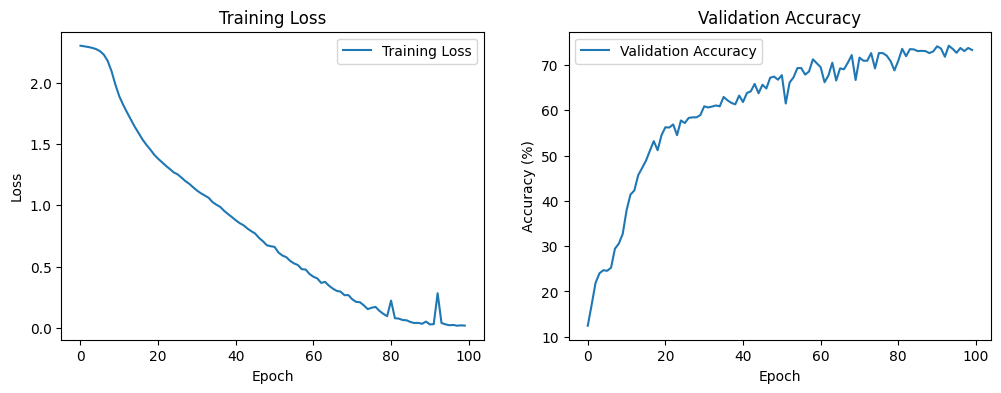

In [37]:
# Графики
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

## Итоговая оценка

Часть кода, которую вы реализовали для оценки модели на валидационной выборке, можно использовать для финальной проверки, указав нужный loader.

In [38]:
with torch.no_grad():
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
      # Ваш код
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)

    print(f'Точность (accuracy) {accuracy}%')

Точность (accuracy) 74.3%


**Точность работы модели на тестовой выборке**

Ваш ответ: 74.3%